# Assets returns forecast with RNNs

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from keras import layers, optimizers
from keras.layers import Input, Dense, LSTM, Dropout,Activation
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import datetime, timedelta
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,6)

Using TensorFlow backend.


In [2]:
# using best configuration from results of hyperparameter space exploration
baseDataset = 'month-month-month-ret'
windowSize = 60

In [3]:
# load dataset
with h5py.File('datasets-{}/train-{}.h5'.format(baseDataset, windowSize), 'r') as hf:
    xTrain = hf['x'][:]
    yTrain = hf['y'][:]
with h5py.File('datasets-{}/val-{}.h5'.format(baseDataset, windowSize), 'r') as hf:
    xVal = hf['x'][:]
    yVal = hf['y'][:]
with h5py.File('datasets-{}/test-{}.h5'.format(baseDataset, windowSize), 'r') as hf:
    xTest = hf['x'][:]
    yTest = hf['y'][:]
    denorm = hf['denorm'][:]

In [4]:
print('Train shape', xTrain.shape, yTrain.shape)
print('Validation shape', xVal.shape, yVal.shape)
print('Test shape', xTest.shape, yTest.shape)

Train shape (85, 60, 19) (85, 19)
Validation shape (10, 60, 19) (10, 19)
Test shape (60, 60, 19) (60, 19)


In [26]:
# model setup
model = Sequential()
model.add(LSTM(256, return_sequences=False, input_shape=(xTrain.shape[1], xTrain.shape[2]), activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=xTrain.shape[2]))
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 256)               282624    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 19)                4883      
Total params: 287,507
Trainable params: 287,507
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# using early stopping as regularization technique
# saving best performing model
callbacks = [
    EarlyStopping(patience=10, monitor='val_loss', min_delta=0, mode='min'),
    ModelCheckpoint('weights-{}.h5'.format(baseDataset), monitor='val_loss', save_best_only=True, save_weights_only=False)
]
# fit model with initial training/validation data
history = model.fit(
    xTrain, yTrain,
    epochs=200, batch_size=64, verbose=1,
    validation_data=(xVal, yVal), shuffle=False,
    callbacks=callbacks)

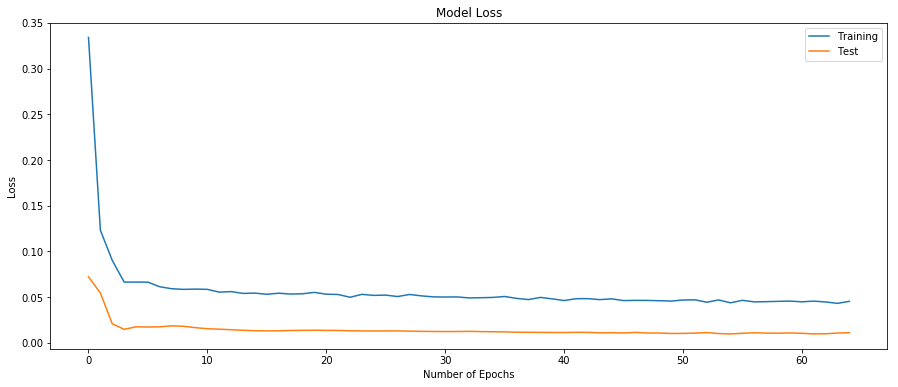

In [28]:
# check loss on training and test set
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(['Training', 'Test'])

In [29]:
# load best model
model.load_weights('weights-{}.h5'.format(baseDataset))
# save best model with architecture, weights and optimizer state
model.save('model-{}.h5'.format(baseDataset))

# check MSE on train, validation and test
trainScore = model.evaluate(xTrain, yTrain, verbose=0)
print('Train Score: {0:.6f} MSE'.format(trainScore[0]))

valScore = model.evaluate(xVal, yVal, verbose=0)
print('Val Score: {0:.6f} MSE'.format(valScore[0]))

testScore = model.evaluate(xTest, yTest, verbose=0)
print('Test Score: {0:.6f} MSE'.format(testScore[0]))

Train Score: 0.042195 MSE
Val Score: 0.009649 MSE
Test Score: 0.033838 MSE


In [30]:
yTest.shape

(60, 19)

In [ ]:
# exploit validation data for further training, limiting the
# number of training epochs
model.fit(
    xVal, yVal,
    epochs=45, batch_size=64, verbose=1,
    shuffle=False,
    callbacks=callbacks)

# 1. Forecast asset prices
Use trained model to forecast asset prices during test period, from 31/12/2013 to 30/11/2018. After each prediction for time $x_{t+1}$, the real asset prices from $x_{t-58}$ to $x_{t+1}$ (60 months) are used for online training, to update the network weights.

In [ ]:
# loop predictions and retrain the model each month
# extract one month at a time, train and then predict using monthly dates
preds = []
mse = []
# get prediction
predictInput = xTest[0].reshape(1, xTest[0].shape[0], xTest[0].shape[1])
outInput = yTest[0].reshape(1, yTest[0].shape[0])
# get error
preds.append(model.predict(predictInput))
mse.append(model.evaluate(predictInput, outInput, verbose=0))

# cycle through monthly dates of yTest
for i in range(yTest.shape[0]-1):
    # retrain the model with the current obs
    predictInput = xTest[i].reshape(1, xTest[i].shape[0], xTest[i].shape[1])
    outInput = yTest[i].reshape(1, yTest[i].shape[0])
    history = model.fit(
        predictInput, outInput,
        epochs=10, batch_size=64, verbose=1,
        shuffle=False,
        callbacks=callbacks)
    trainScore = model.evaluate(predictInput, outInput, verbose=0)
    
    # get prediction for current subset
    predictInput = xTest[i+1].reshape(1, xTest[i+1].shape[0], xTest[i+1].shape[1])
    preds.append(model.predict(predictInput))
    # get error of prediction
    mse.append(model.evaluate(predictInput, outInput, verbose=0))
    
# save best model
model.save('model-{}.h5'.format(baseDataset))

In [33]:
# compute mse of online test set
mse = np.array(mse)
print('Test Score (online learning): {0:.6f} MSE'.format(mse.mean()))

Test Score (online learning): 0.058044 MSE


In [34]:
# convert to numpy array and reshape
preds = np.array(preds)
preds = preds.reshape(preds.shape[0], preds.shape[2])
preds.shape

(60, 19)

In [35]:
# denormalize return predictions
returnPreds = []
returnTrue = []
for i, pred in enumerate(preds):
    dataMin = denorm[i][0]
    dataMax = denorm[i][1]
    predDenorm = pred * (dataMax-dataMin) + dataMin
    returnTrue.append(yTest[i] * (dataMax-dataMin) + dataMin)
    returnPreds.append(predDenorm)
returnPreds = np.array(returnPreds)
returnTrue = np.array(returnTrue)

In [36]:
# get column names from original csv file
columns = pd.Series.from_csv('columns.csv')

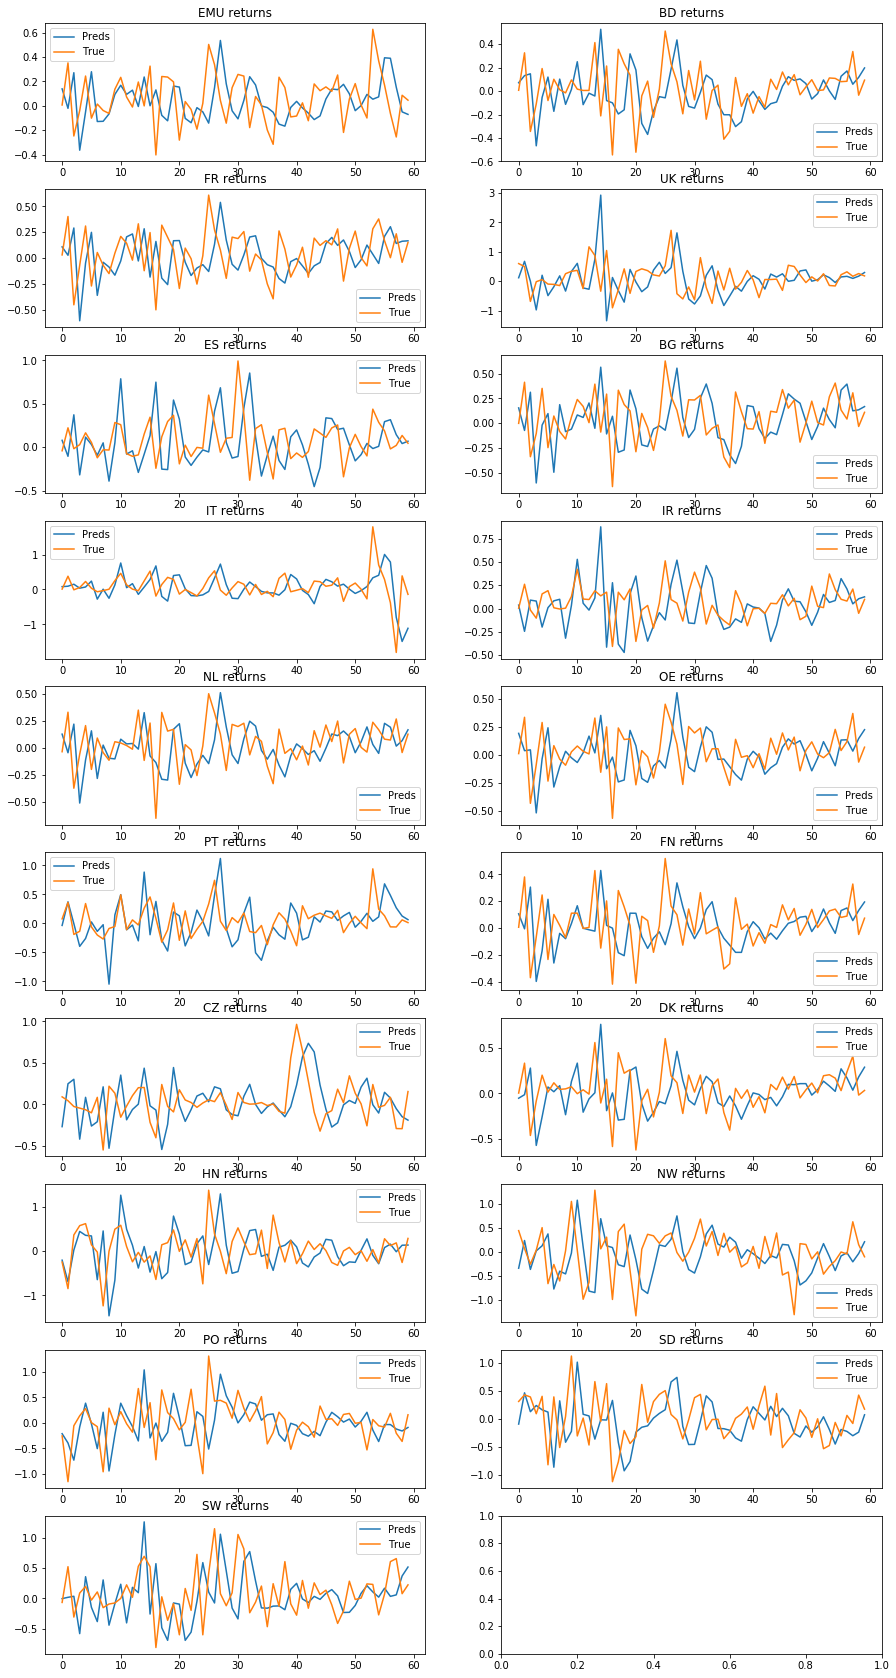

In [37]:
# plot predicted returns for last 5 years vs real ones
fix, ax = plt.subplots(10,2,figsize=(15, 30))
i=0
for r in range(10):
    for c in range(2):
        # do not plot non existing assets
        if i < len(columns):
            ax[r,c].plot(returnPreds[:,i])
            ax[r,c].plot(returnTrue[:,i])
            ax[r,c].legend(['Preds', 'True'])
            ax[r,c].set_title('{} returns'.format(columns[i]))
        i += 1

In [91]:
# save predicted assets returns excluding the benchmark
np.savetxt("returnPredsRNN.csv", returnPreds[:, 1:], delimiter=",")

# 2. Normalized return predictions as proxy for portfolio weights
Each return forecast of the network is the normalized prediction of the $x_{t+1}$ return, given the past returns from $x_{t-58}$ to $x_{t}$. The idea is to use the normalized returns forecast as proxy for the portfolio weights.

In [38]:
# remove bench and normalize predictions to create weights that sum up to 1
predsNorm = preds[:,1:]
predsNorm = predsNorm/np.sum(predsNorm, 1).reshape(predsNorm.shape[0],1)

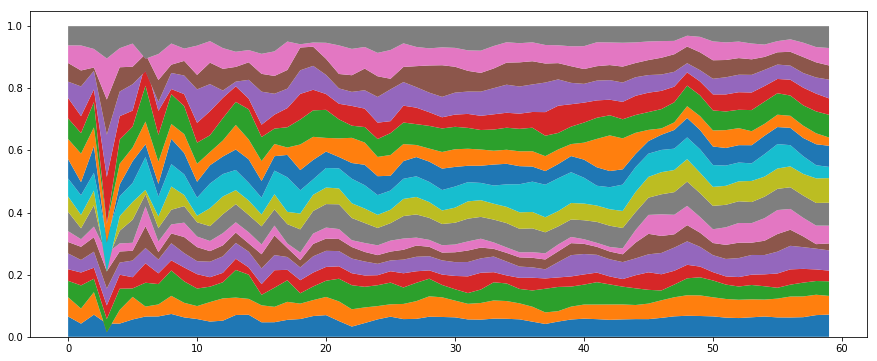

In [93]:
# show weights over time
_ = plt.stackplot(range(predsNorm.shape[0]), predsNorm.T)

In [82]:
# save weights
np.savetxt("weightsRNN.csv", predsNorm, delimiter=",")